# GramCAM for Evaluating Brain Tumor Images

by Christian Moreira

Duke University

AIPI 590 - Explainable AI - Fall 2025

[![Open In Colab](https://img.shields.io/badge/Open%20In-Colab-F9AB00.svg?logo=googlecolab&style=for-the-badge)](https://colab.research.google.com/github/U1186204/GradCAM-in-Brain-Tumor-Classification/blob/main/main.ipynb)

[![GitHub Repo](https://img.shields.io/badge/GitHub-Repo-black.svg?logo=github&style=for-the-badge)](https://github.com/U1186204/GradCAM-in-Brain-Tumor-Classification/tree/main)


#### Importing Packages

In [15]:
# Importing Key Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")



#### Loading Dataset

In [16]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


#### Dataframe Formation

In [17]:
def create_dataframe(base_path):
    """
    Scans the directory structure (Class/Image) and creates a DataFrame
    with image paths and their corresponding class labels.
    """
    classes = []
    class_paths = []

    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)

        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)

                classes.append(label)
                class_paths.append(image_path)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

print("Data loading functions defined.")

Data loading functions defined.


#### Splitting Data into Train/Test Sets

In [18]:
tr_path = os.path.join(path, 'Training')
ts_path = os.path.join(path, 'Testing')

tr_df = create_dataframe(tr_path)
ts_df = create_dataframe(ts_path)

print("Training Data:")
print(tr_df.head())
print(f"\nTraining DataFrame Shape: {tr_df.shape}")

Training Data:
                                          Class Path      Class
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

Training DataFrame Shape: (5712, 2)


#### Brain MRI Distributions in Train and Test Sets

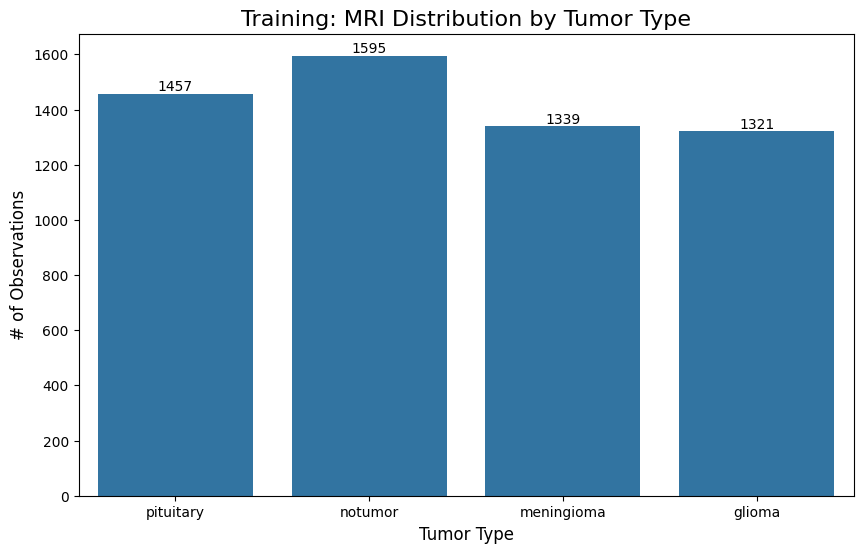

In [19]:

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=tr_df, x='Class')

plt.title('Training: MRI Distribution by Tumor Type', fontsize=16)
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('# of Observations', fontsize=12)

ax.bar_label(ax.containers[0])
plt.show()

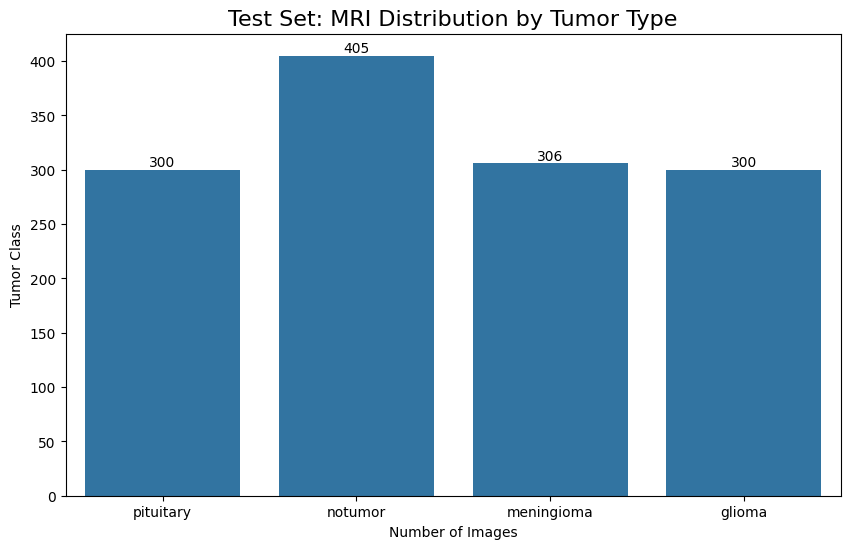

In [20]:

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=ts_df, x='Class')

plt.title('Test Set: MRI Distribution by Tumor Type', fontsize=16)
plt.xlabel('Number of Images')
plt.ylabel('Tumor Class')

ax.bar_label(ax.containers[0])
plt.show()

#### Splitting Data into Train - Test - Validation Sets

In [21]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=42, stratify=ts_df['Class'])

In [22]:
valid_df.head()

,Class Path,Class
537,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
734,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
470,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1169,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
996,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


#### Pre-Processing MRI Images in Train-Test-Validation Sets

In [23]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8,1.2)
    )

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(dataframe = tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = _gen.flow_from_dataframe(dataframe = valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(dataframe = ts_df, x_col='Class Path', y_col='Class', batch_size=16, target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


#### Observing Tumor Samples

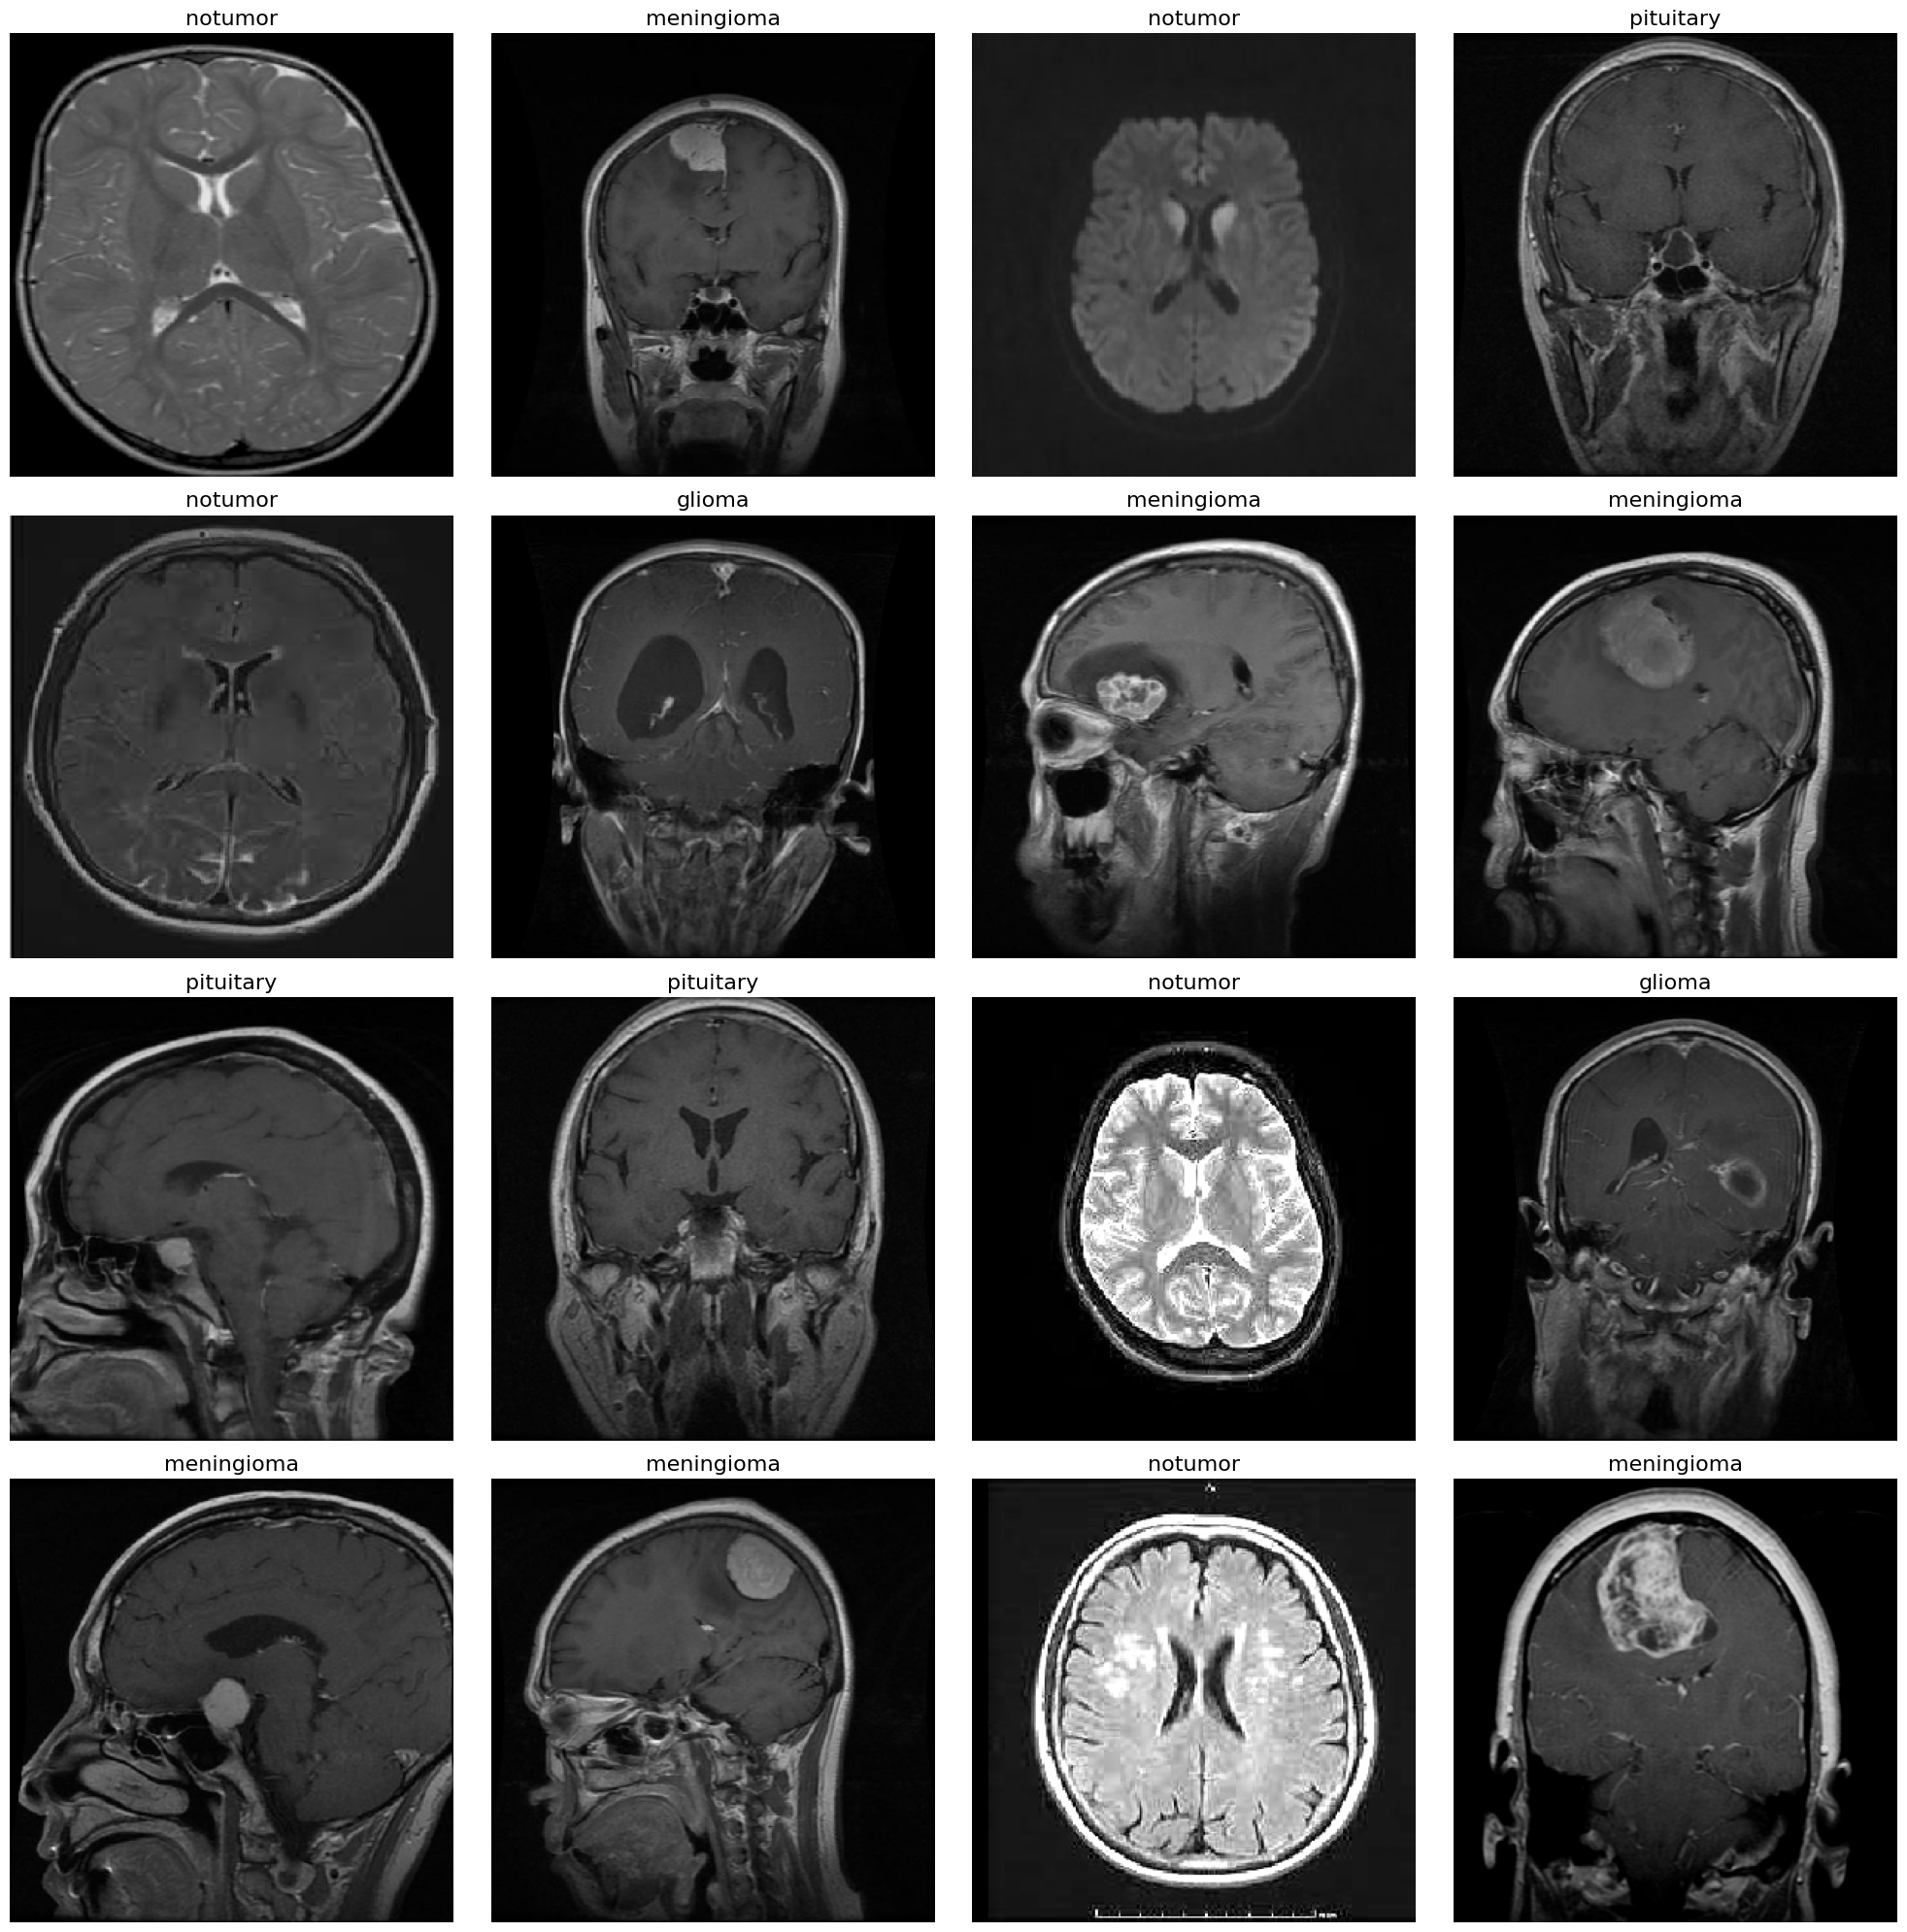

In [27]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    if i >= len(images):
        break

    image = images[i]
    label = labels[i]

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)

    if label.ndim > 0:
        class_index = np.argmax(label)
    else:
        class_index = int(label)

    class_name = classes[class_index]

    plt.title(class_name, color='k', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Deep Learning Model

In [ ]:
img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape = img_shape, pooling= 'max')